# Case Study 0: Fall Creek Watershed, NY

Read in observation, parameter and model output datasets from 5000 SWMM model runs.
(Update this to read from github folder layout)

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

folder = '/Users/catiefinkenbiner/Documents/Summer Institute/CaseStudies/Case Study 0/FallCreekWS/SWMM_5000'
df_obs = pd.read_csv(folder+'/SWMM_observations.csv')
df_parms = pd.read_csv(folder+'/SWMM_parameters.csv')
df_model = pd.read_csv(folder+'/SWMM_simulations.csv')

### 1. Graph Observed and Modeled Output

In [2]:
%run timeseries_plots.py

### XX. Approximate Bayesian Calculation
Write stuff about ABC...

Specify the number of model runs (5000), tolerance of the objective function (NSE >= 0.90), number of histogram bins (100) and the figure colors (color1, color2).

In [42]:
# %load approx_bayes_calc.py 
#!/usr/bin/env python3
'''
Approximate Baysian Calculation requires:
    1) observation dataset (df_obs)
    2) parameter sets (df_parms)
    3) model output (df_model)
    4) tolerance
    5) number of model runs
'''
def approx_bayes_calc(obs,parms,models,simulations,tolerance):
    keep = []
    for i in np.arange((simulations)):
        # 1) Observed datasets has known mean and standard deviation
        obs_mu = obs.mean()
        obs_sigma = obs.std()
        # 2) Parameters (theta)
        theta = parms.iloc[i,1:]
        # 3) Calculate objective function (NSE)
        bias = (models.iloc[i,1:] - obs.iloc[0,1:])
        mse = (bias**2).sum() # mean-squared error
        nse = 1 - mse/((models.iloc[i,:]-obs_mu)**2).sum()# nash-sutcliffe efficiency
        # 4) Define tolerance and calculate
        if nse >= tolerance:
                keep.append(parms.loc[i])        
    return keep

def make_histograms(df_parms,bayes_approx,bins,alpha,cc1,cc2,parameters):
    plt.figure(figsize=(12,12))
    for col in np.arange(1,((df_parms.iloc[0,:]).size)):
        plt.subplot(4,3,col)
        ax = df_parms.iloc[:,col].plot.hist(bins=bins,alpha=alpha,color=cc1)    
        ax = bayes_approx.iloc[:,col].plot.hist(bins=bins,alpha=alpha,color=cc2)
        ax.set_xlabel(str(parameters[col]))    
    #plt.legend('Output','ABC')
    plt.tight_layout()   

def runABC(df_obs,df_parms,df_model,runs,tolerance,bins,color1,color2):
    df_obs = pd.read_csv(df_obs)
    df_parms = pd.read_csv(df_parms)
    df_model = pd.read_csv(df_model)
    results = np.array(approx_bayes_calc(df_obs,df_parms,df_model,runs,tolerance))
    print('precent of models with NSE >= to',str(tolerance),'are:',str(len(results)/runs),'%')
    bayes_approx = pd.DataFrame(results,columns=None)
    parameters = list(df_parms.columns.values)
    make_histograms(df_parms,bayes_approx,bins,0.5,color1,color2,parameters)

precent of models with NSE >= to 0.9 are: 0.7646 %


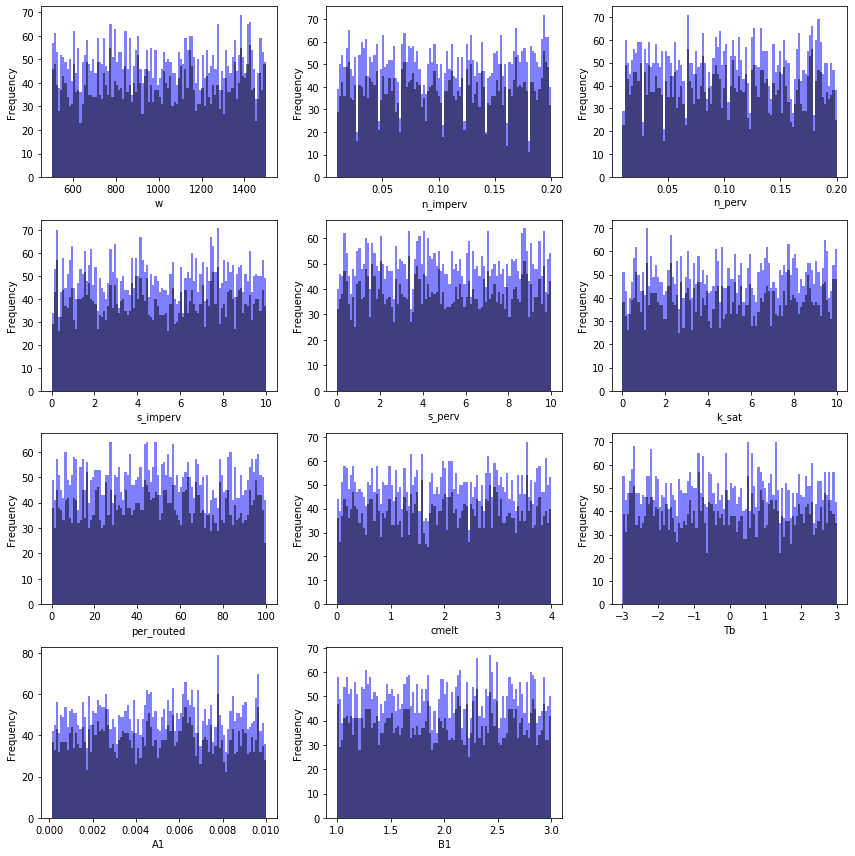

In [41]:
runs = 5000 # number of model runs
tolerance = 0.90 # tolerance specific to objective function
bins = 100 # bins for histogram
color1 = 'b' # graph color of model outputs
color2 = 'k' # graph color of approx. bayesian calculation

runABC(df_obs,df_parms,df_model,runs,tolerance,bins,color1,color2)